In [1]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import pandas as pd
from config import pickle_file
from tqdm import tqdm
import nltk
import collections
import numpy as np
import os
import librosa

In [2]:
# 导入生成文件
with open(pickle_file, 'rb') as file:
    data = pickle.load(file)

In [3]:
keys = data.keys()
# 打印键列表
for key in keys:
    print(key)

VOCAB
IVOCAB
train
dev
test


In [4]:
print('训练集:'+str(len(data['train'])))
print('dev:'+str(len(data['dev'])))
print('test:'+str(len(data['test'])))
print('vocab_size:' + str(len(data['VOCAB'])))

训练集:120098
dev:14326
test:7176
vocab_size:4335


In [5]:
# 统计一下二元组
char_list = data['IVOCAB']
vocab_size = len(char_list)
samples = data['train']
bigram_counter = collections.Counter()

for sample in tqdm(samples):
    text = sample['trn']
    # text = [char_list[idx] for idx in text]
    tokens = list(text)
    bigrm = nltk.bigrams(tokens)
    bigram_counter.update(bigrm)
print(bigram_counter.most_common(10))

  0%|          | 0/120098 [00:00<?, ?it/s]

100%|██████████| 120098/120098 [00:01<00:00, 109576.85it/s]

[((24, 298), 4302), ((5, 146), 3791), ((147, 366), 3562), ((275, 356), 2870), ((356, 68), 2790), ((365, 70), 2729), ((365, 142), 2591), ((451, 183), 2547), ((65, 5), 2439), ((293, 133), 2376)]


In [6]:
# 打印一下最多的三个二元组
print(char_list[24],char_list[298])
print(char_list[5],char_list[146])
print(char_list[147],char_list[366])

中 国
市 场
公 司


In [7]:
# 将频数转为出现概率统计并保存
# temp_dict = dict()
# for key, value in bigram_counter.items():
#     temp_dict[key] = value

# print('smoothing and freq -> prob')
# bigram_freq = dict()
# # 整个的字符表
# for i in tqdm(range(vocab_size)):
#     freq_list = []
#     for j in range(vocab_size):
#         if (i, j) in temp_dict:
#             freq_list.append(temp_dict[(i, j)])
#         else:
#             # 保证每个字符对至少一次
#             freq_list.append(1)

#     freq_list = np.array(freq_list)
#     freq_list = freq_list / np.sum(freq_list)

#     assert (len(freq_list) == vocab_size)
#     bigram_freq[i] = freq_list

# print(len(bigram_freq[0]))
# with open('bigram_freq.pkl', 'wb') as file:
#     pickle.dump(bigram_freq, file)

In [8]:
# 打印一下第一个编码
print(char_list[0])

<sos>


In [9]:
# print(bigram_freq[1][1])

In [10]:
# 添加噪声
def spec_augment(spec: np.ndarray, num_mask=2, 
                 freq_masking_max_percentage=0.15, time_masking_max_percentage=0.3):

    spec = spec.copy()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = 0

        time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = 0
    
    return spec

In [11]:
audio_path = os.path.join("../dataset/data_aishell/wav/train/S0002/BAC009S0002W0122.wav")
sr, audio = wavfile.read(audio_path)

x = librosa.feature.melspectrogram(y=audio.astype(float), sr=sr, S=None, n_fft=512, hop_length=256, n_mels=40).T
x = librosa.power_to_db(x, ref=np.max)

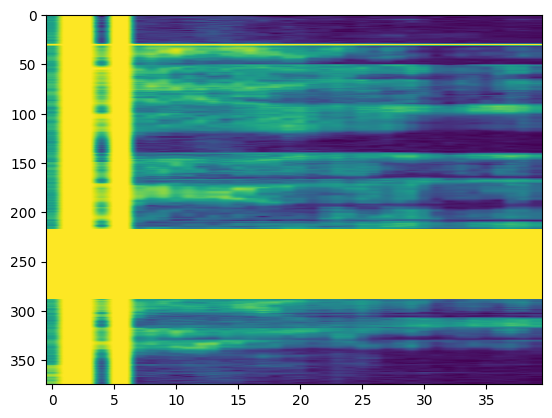

In [12]:
plt.figure()
plt.imshow(spec_augment(x),aspect= 'auto')
plt.show()

In [13]:
# 抽帧
def build_LFR_features(inputs, m, n):
    """
    Actually, this implements stacking frames and skipping frames.
    if m = 1 and n = 1, just return the origin features.
    if m = 1 and n > 1, it works like skipping.
    if m > 1 and n = 1, it works like stacking but only support right frames.
    if m > 1 and n > 1, it works like LFR.
    Args:
        inputs_batch: inputs is T x D np.ndarray
        m: number of frames to stack
        n: number of frames to skip
    """
    # LFR_inputs_batch = []
    # for inputs in inputs_batch:
    LFR_inputs = []
    T = inputs.shape[0]
    T_lfr = int(np.ceil(T / n))
    for i in range(T_lfr):
        if m <= T - i * n:
            LFR_inputs.append(np.hstack(inputs[i * n:i * n + m]))
        else:  # process last LFR frame
            num_padding = m - (T - i * n)
            frame = np.hstack(inputs[i * n:])
            for _ in range(num_padding):
                frame = np.hstack((frame, inputs[-1]))
            LFR_inputs.append(frame)
    return np.vstack(LFR_inputs)

In [14]:
audio_path = os.path.join("../dataset/data_aishell/wav/train/S0002/BAC009S0002W0122.wav")
sr, audio = wavfile.read(audio_path)

x = librosa.feature.melspectrogram(y=audio.astype(float), sr=sr, S=None, n_fft=512, hop_length=256, n_mels=40).T
x = librosa.power_to_db(x, ref=np.max)

In [15]:
feature1 = spec_augment(x)
# 明显看出n的作用
feature = build_LFR_features(feature1, m=1, n=10)

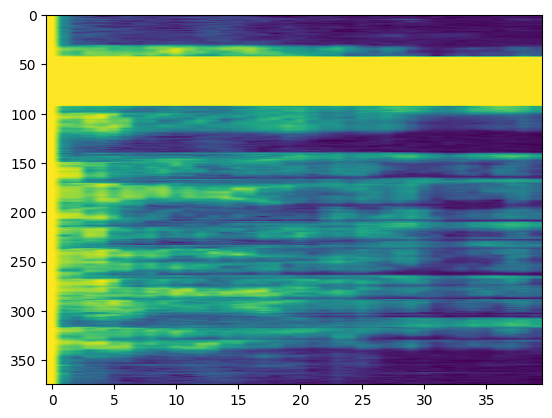

In [16]:
plt.figure()
plt.imshow(feature1,aspect= 'auto')
plt.show()

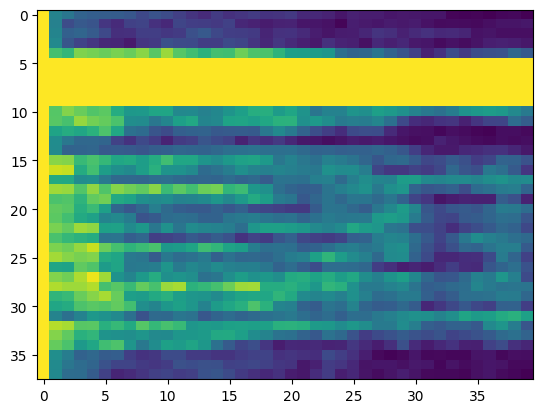

In [17]:
plt.figure()
plt.imshow(feature,aspect= 'auto')
plt.show()

测试各种训练

In [18]:
# 测试data——process
from torch.utils.data import DataLoader
import data_process
dataset=data_process.AiShellDataset('test')
first_data = dataset[0]
feature,trn=first_data

In [19]:
# 查看输入输出数据集
print(feature,trn)
print(feature.shape,len(trn))

[[-0.3262395   0.17098634  0.31233305 ... -0.7408709  -0.7317126
  -0.63851285]
 [ 0.17852771  0.13855937 -0.3834093  ... -0.685384   -0.6265054
  -0.6549062 ]
 [ 0.4784395  -0.08476716 -0.9655915  ... -0.73383915 -0.6200245
  -0.59371793]
 ...
 [ 1.4995568   1.59078     1.3565599  ... -0.8034648  -0.8160007
  -0.6473056 ]
 [ 0.35263103 -0.22914332 -0.19947994 ... -0.89558774 -0.7786102
  -0.6196669 ]
 [ 1.4995587   1.4148687   0.07129297 ... -0.8218369  -0.80060863
  -0.66357666]] [1041, 1034, 90, 372, 7, 643, 1038, 1039, 699, 1460, 14, 272, 1098, 1]
(138, 320) 14


In [20]:
for i in trn:
    print(char_list[i],end="")

甚至出现交易几乎停滞的情况<eos>

In [21]:
data['test'][0]

{'trn': [1041, 1034, 90, 372, 7, 643, 1038, 1039, 699, 1460, 14, 272, 1098, 1],
 'wave': '../dataset/data_aishell/wav\\test\\S0764\\BAC009S0764W0121.wav'}

In [22]:
from padding import pad_collate
# 填充使得每批大小一定,形成矩阵,注意是每批,批与批之间不一定大小相同
dataloader=DataLoader(dataset, batch_size=32, collate_fn=pad_collate,
                                               pin_memory=True, shuffle=True, num_workers=4)

In [23]:
datatiter=iter(dataloader)
batch=next(datatiter)
# print(batch[0])
# print(batch[1])

In [24]:
# batch[0]即输入的一批数据
print(batch[0].shape)
print(batch[1].shape)
print(batch[2])

torch.Size([32, 292, 320])
torch.Size([32, 23])
tensor([292, 280, 228, 194, 191, 186, 181, 179, 177, 174, 174, 170, 169, 150,
        146, 134, 133, 128, 127, 126, 123, 123, 115, 103, 101,  95,  91,  91,
         89,  76,  54,  47])


In [25]:
# # 可以这样获取一批数据
# for i, (data) in enumerate(dataloader):
#     padded_input, padded_target, input_lengths = data
#     print(padded_input.shape)
#     print(padded_target.shape)
#     print(input_lengths)
#     break

In [26]:
from config import device
import torch
from model.PositionalEncoding import PositionalEncoding
# 卷积后的输入
d_input=159
d_model=512

In [27]:
# 输入先卷积
from model.InputEncoding import InputEncoding
conv=InputEncoding()
incov=conv.forward(batch[0])
print(incov.shape)

torch.Size([32, 145, 159])


In [28]:
import torch.nn as nn
# linear只改变最后一维,所以经过了linear层变为如下
m = nn.Linear(d_input, d_model)
IE = m(incov)
print(IE.size())

torch.Size([32, 145, 512])


In [29]:
pe=PositionalEncoding(d_model=512,max_len=5000)
PE=pe.forward(incov)
print(PE.shape)

torch.Size([145, 512])


In [30]:
input_encoder=PE+IE

In [31]:
ln=torch.nn.LayerNorm(d_model)
ln.forward(input_encoder)

tensor([[[-1.0131,  0.7854, -1.3197,  ...,  0.6526, -0.7731,  0.9425],
         [ 0.1050,  0.8351,  0.2514,  ...,  0.4878, -0.1939,  1.2891],
         [ 0.1448, -1.4778,  0.5638,  ..., -0.0958, -0.1468,  1.1587],
         ...,
         [-1.4451, -1.6812, -1.8932,  ...,  1.0369, -0.5011,  1.1545],
         [-2.0732, -0.3572, -0.9060,  ...,  1.0507, -0.4664,  1.1519],
         [-1.2982,  0.8932,  0.5069,  ...,  1.0693, -0.5030,  1.1670]],

        [[-1.1452,  0.8084, -0.9856,  ...,  0.4100, -0.8491,  0.7461],
         [ 0.4708, -0.0905,  0.6865,  ...,  0.8111, -1.0568,  1.3318],
         [ 0.8853, -1.8498,  0.5956,  ...,  1.1104, -0.8933,  0.7199],
         ...,
         [-1.4393, -1.7063, -1.9740,  ...,  1.1029, -0.4732,  1.1074],
         [-2.0577, -0.3789, -0.9173,  ...,  1.1157, -0.4501,  1.1041],
         [-1.2860,  0.8783,  0.4595,  ...,  1.0926, -0.4661,  1.0961]],

        [[-1.6490,  0.8771, -1.2993,  ...,  0.1391, -0.9671,  1.0294],
         [ 0.1451, -0.1903,  0.3351,  ...,  0

In [33]:
from  model.Encoder import Encoder
from model.InputEncoding import InputEncoding
encoder=Encoder()
encoder_out=encoder.forward(batch[0])
print(encoder_out)

tensor([[[-0.3612, -0.0940, -1.2465,  ..., -1.6513, -2.9275,  1.2579],
         [-0.9398, -0.7427, -0.9571,  ..., -1.4953, -2.7119,  1.4714],
         [-0.7335, -1.7459, -0.3064,  ..., -0.8341, -3.8477,  0.7950],
         ...,
         [-1.0868, -1.5942, -2.4541,  ..., -0.1819, -2.3216,  0.6220],
         [-1.9233, -0.3957, -2.4316,  ..., -0.6031, -1.8542,  0.4266],
         [-1.5141, -0.1790, -2.0909,  ..., -0.3148, -1.0200,  1.0472]],

        [[-0.5110, -0.9829, -1.6163,  ..., -0.1636, -3.6540,  0.3569],
         [-0.2321, -0.7703, -0.8584,  ..., -1.0876, -3.1820,  1.4614],
         [-0.1253, -2.4493, -1.0780,  ..., -0.9192, -3.4952,  0.8469],
         ...,
         [-1.1743, -0.9338, -2.6254,  ..., -0.1668, -1.6663,  0.2479],
         [-1.1893, -0.4501, -2.2765,  ...,  0.3225, -1.7419,  0.6889],
         [-0.8665,  0.2946, -1.6033,  ..., -0.4486, -1.4694,  0.5724]],

        [[-0.4659,  0.0728, -1.7041,  ..., -1.1401, -3.5973,  1.0502],
         [ 0.0643, -1.2936, -1.4069,  ..., -1